# Import statements 

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
from  my_ml_lib import MetricTools, PlotTools

In [4]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pickle
import pandas as pd 
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure 
import json
import datetime
import copy
from PIL import Image as im
import joblib
from sklearn.model_selection import train_test_split
# import math as Math
import random
import torch.optim

In [5]:
import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
import torchvision

In [6]:
import cv2

# Saving and Loading code 

In [7]:
# Saving and Loading models using joblib 
def save(filename, obj):
  with open(filename, 'wb') as handle:
      joblib.dump(obj, handle, protocol=pickle.HIGHEST_PROTOCOL)

def load(filename):
  with open(filename, 'rb') as handle:
      return joblib.load(filename)


# Importing Dataset 

In [8]:
data_path = "/content/drive/MyDrive/SEM-2/05-DL /Assignments/A3/dataset/train.pkl"
x = load(data_path)

In [9]:
# save_path = "/content/drive/MyDrive/SEM-2/05-DL /Assignments/A3/dataset/"
# # saving the images and labels array 
# save(save_path + "data_image.pkl",data_image)
# save(save_path + "data_label.pkl",data_label)
# # dict values where labels key and image arrays as vlaues in form of list 
# save(save_path + "my_dict.pkl",my_dict)

In [10]:
save_path = "/content/drive/MyDrive/SEM-2/05-DL /Assignments/A3/dataset/"
# saving the images and labels array 
data_image = load(save_path + "data_image.pkl")
data_label = load(save_path + "data_label.pkl")
# dict values where labels key and image arrays as vlaues in form of list 
my_dict = load(save_path + "my_dict.pkl")

In [11]:
len(data_image) , len(data_label), my_dict.keys()

(5000, 5000, dict_keys([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]))

# Data Class and Data Loaders and Data transforms 

In [12]:
len(x['names']) ,x['names'][4999] , data_image[0].shape

(5000, 'train05000', (32, 32, 3))

## Splitting the data into train and val

In [13]:
X_train, X_test, y_train, y_test = train_test_split(data_image, data_label, test_size=0.10, random_state=42,stratify=data_label )

In [14]:
len(X_train) , len(y_train) , len(X_test) ,len(y_test)

(4500, 4500, 500, 500)

In [15]:
pd.DataFrame(y_test).value_counts() 

9    50
8    50
7    50
6    50
5    50
4    50
3    50
2    50
1    50
0    50
dtype: int64

## Data Class

In [16]:
class myDataClass(Dataset):
  """Custom dataset class"""

  def __init__(self, images, labels , transform=None):

    """
    Args:
        images : Array of all the images 
        labels : Correspoing labels of all the images 
    """
    
    self.images = images
    self.labels = labels
    self.transform = transform
    
  def __len__(self):

    return len(self.images)

  def __getitem__(self, idx):
    # converts image value between 0 and 1 and returns a tensor C,H,W 
    img = torchvision.transforms.functional.to_tensor(self.images[idx])
    target = self.labels[idx]
    

    if self.transform:
        img = self.transform(img)
    return img,target 

## Data Loaders 

In [17]:
batch = 64
train_dataset = myDataClass(X_train, y_train)
test_dataset = myDataClass(X_test, y_test)

train_dataloader = DataLoader(train_dataset, batch_size= batch, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size= batch, shuffle=True)

In [18]:
# next(iter(train_dataloader))[0].shape

In [19]:
len(train_dataloader) , len(test_dataloader)

(71, 8)

# Train and Test functions 

In [20]:
def load_best(all_models,model_test):
  FILE  = all_models[-1]
  
  criterion = nn.CrossEntropyLoss()
  optimizer = optim.Adam(model_test.parameters(), lr=0)

  checkpoint = torch.load(FILE)
  model_test.load_state_dict(checkpoint['model_state'])
  optimizer.load_state_dict(checkpoint['optim_state'])
  epoch = checkpoint['epoch']
  model_test.eval()

  return model_test


In [21]:
def train(save_path,epochs,train_dataloader,model,test_dataloader,optimizer,criterion,basic_name):
  model_no = 1
  c = 1
  all_models = []

  valid_loss_min = np.Inf 
  train_losses = []
  val_losses = []

  for e in range(epochs):

      train_loss = 0.0
      valid_loss = 0.0

      model.train()
      
      for idx, (images,labels) in enumerate(train_dataloader):
        
          images, labels = images.to(device) , labels.to(device) 
    
          optimizer.zero_grad()        
          log_ps= model(images)
          loss = criterion(log_ps, labels)
          loss.backward()
          optimizer.step()
          
          train_loss += ((1 / (idx + 1)) * (loss.data - train_loss))
      else:

          accuracy = 0
          correct = 0
          model.eval()

          with torch.no_grad():
              for idx, (images,labels) in enumerate(test_dataloader):

                  images, labels = images.to(device) , labels.to(device)

                  log_ps = model(images)
                  
                  _, predicted = torch.max(log_ps.data, 1)
                  loss = criterion(log_ps, labels)

                  # correct += (predicted == labels).sum().item()
                  equals = predicted == labels.view(*predicted.shape)
                  accuracy += torch.mean(equals.type(torch.FloatTensor))
                  valid_loss += ((1 / (idx + 1)) * (loss.data - valid_loss))

          print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
              e+1, 
              train_loss,
              valid_loss
              ), "Test Accuracy: {:.3f}".format(accuracy/len(test_dataloader)))

          train_losses.append(train_loss)
          val_losses.append(valid_loss)

          if valid_loss < valid_loss_min:
            
            print('Saving model..' + str(model_no))
            valid_loss_min = valid_loss

            checkpoint = {
            "epoch": e+1,
            "model_state": model.state_dict(),
            "optim_state": optimizer.state_dict(),
            "train_losses": train_losses,
            "test_losses": val_losses,
            }

            FILE =  save_path + basic_name +"_epoch_" + str(e+1) + "_model_" +  str(model_no)
            all_models.append(FILE)
            torch.save(checkpoint, FILE)
            model_no = model_no + 1
          
  
  save(save_path + basic_name + "_all_models.pkl", all_models)
  return model, train_losses, val_losses, all_models 
   

In [22]:
def plot(train_losses,val_losses,title='Training Validation Loss with CNN'):
  plt.plot(train_losses, label='Training loss')
  plt.plot(val_losses, label='Validation loss')
  plt.xlabel('Iterations')
  plt.ylabel('Loss')
  plt.legend()
  _ = plt.ylim()
  plt.title(title)
  # plt.savefig('plots/Training Validation Loss with CNN from scratch.png')
  plt.show()

In [23]:
def test(loader, model, criterion, device, name):
    test_loss = 0.
    correct = 0.
    total = 0.
    y = None
    y_hat = None
    
    model.eval()
    for batch_idx, (images, labels) in enumerate(loader):

        # move to GPU or CPU
        images, labels = images.to(device)   , labels.to(device) 
        target = labels

        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(images)
        # calculate the loss
        loss = criterion(output,labels)
        # update average test loss 
        test_loss = test_loss + ((1 / (batch_idx + 1)) * (loss.data - test_loss))
        # convert output probabilities to predicted class
        pred = output.data.max(1, keepdim=True)[1]

        if y is None:
            y = target.cpu().numpy()
            y_hat = pred.data.cpu().view_as(target).numpy()
        else:
            y = np.append(y, target.cpu().numpy())
            y_hat = np.append(y_hat, pred.data.cpu().view_as(target).numpy())


        correct += np.sum(pred.view_as(labels).cpu().numpy() == labels.cpu().numpy())
        total = total + images.size(0)
        # if batch_idx % 20 == 0:
        #     print("done till batch" , batch_idx+1)
            
    print(name + ' Loss: {:.6f}\n'.format(test_loss))

    print(name + ' Accuracy: %2d%% (%2d/%2d)' % (
        100. * correct / total, correct, total))
    return y, y_hat

In [24]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [25]:
# def train(save_path,epochs,train_dataloader,model,test_dataloader,optimizer,criterion,basic_name)
# def plot(train_losses,val_losses,title='Training Validation Loss with CNN')
# def test(loader, model, criterion, device)

# Relu [ X=2 Y=3 Z=1 ] 

## CNN - Block-1 

### model 

In [26]:
cfg1 = {
    'B1': [16,16,'M'],
}

In [27]:
def make_layers1(cfg, batch_norm=True):

    layers = []
    in_channels = 3
    for v in cfg:
        if v == 'M':
            layers += [nn.MaxPool2d(kernel_size=4, stride=3)]
        elif v == 'M1':
            layers += [nn.MaxPool2d(kernel_size=2, stride=(1,2),padding=(0,1))]
        else:
            conv2d = nn.Conv2d(in_channels, v, kernel_size=3, padding=1)
            if batch_norm:
                layers += [conv2d, nn.BatchNorm2d(v), nn.ReLU(inplace=True)]
            else:
                layers += [conv2d, nn.ReLU(inplace=True)]
            in_channels = v

    return nn.Sequential(*layers)

In [28]:
class Model_B1(nn.Module):

    def __init__(self, features):

        super(Model_B1, self).__init__()
        self.features = features
        self.classifier = nn.Sequential(
            nn.Linear(1600, 512),
            nn.ReLU(True),
            nn.Dropout(p=0.7),
            nn.Linear(512, 256),
            nn.ReLU(True),
            nn.Dropout(p=0.7),
            nn.Linear(256, 64),
            
            nn.ReLU(True),
            nn.Dropout(p=0.7),
            nn.Linear(64, 10),
        )

    def forward(self, x):
        x = self.features(x)
        # print(x.shape)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

In [29]:
# m = Model_B1(make_layers1(cfg1['B1']))
# for i,l in train_dataloader:
#   o = m(i)

In [30]:
model1 = Model_B1(make_layers1(cfg1['B1'])).to(device) 
learning_rate = 0.01
criterion1 = nn.CrossEntropyLoss()
optimizer1 = optim.Adam(model1.parameters(), lr=learning_rate)
print(model1)

Model_B1(
  (features): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=4, stride=3, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Linear(in_features=1600, out_features=512, bias=True)
    (1): ReLU(inplace=True)
    (2): Dropout(p=0.7, inplace=False)
    (3): Linear(in_features=512, out_features=256, bias=True)
    (4): ReLU(inplace=True)
    (5): Dropout(p=0.7, inplace=False)
    (6): Linear(in_features=256, out_features=64, bias=True)
    (7): ReLU(inplace=True)
    (8): Dropout(p=0.7, inplace=False)
    (9): Linear(in_features=64, out_features=10, bias=True)
  )
)


###train

In [31]:
# !rm  '/content/drive/MyDrive/SEM-2/05-DL /Assignments/A3/models_saved_Q1/1_3/bw_fc/Dropout(0.7)/cnn_block1/'*
# !ls  '/content/drive/MyDrive/SEM-2/05-DL /Assignments/A3/models_saved_Q1/1_3/bw_fc/Dropout(0.7)/cnn_block1/'

In [32]:
save_path1 = "/content/drive/MyDrive/SEM-2/05-DL /Assignments/A3/models_saved_Q1/1_3/bw_fc/Dropout(0.7)/cnn_block1/"

In [33]:

# /content/drive/MyDrive/SEM-2/05-DL /Assignments/A3/models_saved_Q1/1_2/cnn_block123
# /content/drive/MyDrive/SEM-2/05-DL /Assignments/A3/models_saved_Q1/1_2/cnn_block12
# /content/drive/MyDrive/SEM-2/05-DL /Assignments/A3/models_saved_Q1/1_2/cnn_block1

m, train_losses, val_losses,m_all_models = train(save_path1,100,train_dataloader,model1,test_dataloader,optimizer1,criterion1,"cnn_b1")

Epoch: 1 	Training Loss: 2.532094 	Validation Loss: 2.302740 Test Accuracy: 0.101
Saving model..1
Epoch: 2 	Training Loss: 2.317899 	Validation Loss: 2.302772 Test Accuracy: 0.101
Epoch: 3 	Training Loss: 2.310088 	Validation Loss: 2.302696 Test Accuracy: 0.100
Saving model..2
Epoch: 4 	Training Loss: 2.312868 	Validation Loss: 2.302730 Test Accuracy: 0.099
Epoch: 5 	Training Loss: 2.307335 	Validation Loss: 2.302779 Test Accuracy: 0.099
Epoch: 6 	Training Loss: 2.304634 	Validation Loss: 2.302778 Test Accuracy: 0.100
Epoch: 7 	Training Loss: 2.304400 	Validation Loss: 2.302853 Test Accuracy: 0.098
Epoch: 8 	Training Loss: 2.303913 	Validation Loss: 2.302632 Test Accuracy: 0.100
Saving model..3
Epoch: 9 	Training Loss: 2.303913 	Validation Loss: 2.302749 Test Accuracy: 0.099
Epoch: 10 	Training Loss: 2.305637 	Validation Loss: 2.302896 Test Accuracy: 0.100
Epoch: 11 	Training Loss: 2.308787 	Validation Loss: 2.302663 Test Accuracy: 0.100
Epoch: 12 	Training Loss: 2.305221 	Validation L

### Plots and test 

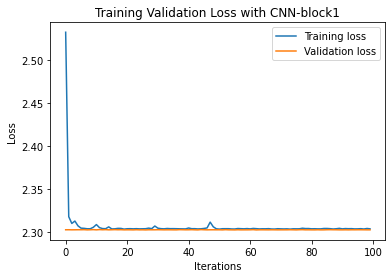

In [34]:
plot(train_losses,val_losses,'Training Validation Loss with CNN-block1')

In [35]:
all_models1 = load(save_path1 + "cnn_b1_all_models.pkl")
FILE  = all_models1[-1]
m = Model_B1(make_layers1(cfg1['B1'])).to(device) 

In [36]:
m = load_best(all_models1,m)

In [37]:
train_y, train_y_hat = test(train_dataloader, m, criterion1, device, "TRAIN")

TRAIN Loss: 2.302673

TRAIN Accuracy: 10% (450/4500)


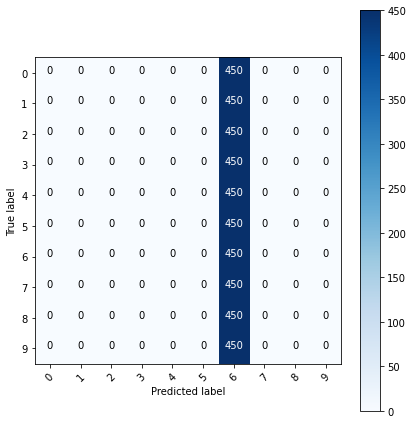

In [38]:
cm = MetricTools.confusion_matrix(train_y, train_y_hat, nclasses=10)
PlotTools.confusion_matrix(cm, [i for i in range(10)], title='',
                           filename='Confusion Matrix with CNN', figsize=(6,6))

In [39]:
test_y, test_y_hat = test(test_dataloader, m, criterion1, device,"TEST")

TEST Loss: 2.302647

TEST Accuracy: 10% (50/500)


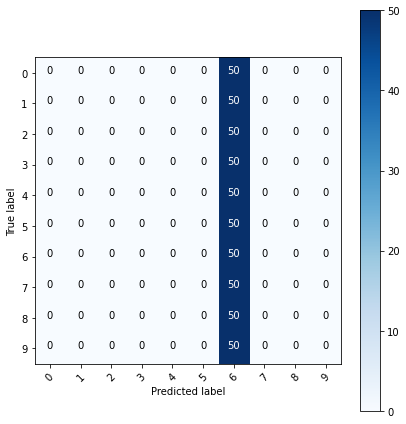

In [40]:
cm = MetricTools.confusion_matrix(test_y, test_y_hat, nclasses=10)
PlotTools.confusion_matrix(cm, [i for i in range(10)], title='',
                           filename='Confusion Matrix with CNN', figsize=(6,6))

## CNN-Block12

### model 

In [41]:
cfg2 = {
    'B12': [16,16,'M', 32, 32, 32,'M'],
}

In [42]:
def make_layers2(cfg, batch_norm=True):

    layers = []
    in_channels = 3
    for v in cfg:
        if v == 'M':
            layers += [nn.MaxPool2d(kernel_size=2, stride=2)]
        elif v == 'M1':
            layers += [nn.MaxPool2d(kernel_size=2, stride=1,padding=1)]
        else:
            conv2d = nn.Conv2d(in_channels, v, kernel_size=3)
            if batch_norm:
                layers += [conv2d, nn.BatchNorm2d(v), nn.ReLU(inplace=True)]
            else:
                layers += [conv2d, nn.ReLU(inplace=True)]
            in_channels = v

    return nn.Sequential(*layers)

In [43]:
class Model_B12(nn.Module):
    '''
        Model
    '''
    def __init__(self, features):

        super(Model_B12, self).__init__()
        self.features = features
        self.classifier = nn.Sequential(
            # nn.Linear(3200, 512),
            # nn.ReLU(True),
            nn.Linear(512, 256),
            nn.ReLU(True),
            nn.Dropout(p=0.7),
            nn.Linear(256, 64),
            nn.ReLU(True),
            nn.Dropout(p=0.7),
            nn.Linear(64, 10),
        )

    def forward(self, x):
        x = self.features(x)
        # print(x.shape)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

In [44]:
# m = Model_B12(make_layers2(cfg2['B12']))
# for i,l in train_dataloader:
#   o = m(i)

In [45]:
model2 = Model_B12(make_layers2(cfg2['B12'])).to(device) 
learning_rate = 0.01
criterion2 = nn.CrossEntropyLoss()
optimizer2 = optim.Adam(model2.parameters(), lr=learning_rate)
print(model2)

Model_B12(
  (features): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1))
    (4): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
    (8): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace=True)
    (10): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1))
    (11): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace=True)
    (13): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1))
    (14): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (15): ReLU(inplace=

### Train 

In [46]:
# !rm  '/content/drive/MyDrive/SEM-2/05-DL /Assignments/A3/models_saved_Q1/1_3/bw_fc/Dropout(0.7)/cnn_block12/'*
# !ls  '/content/drive/MyDrive/SEM-2/05-DL /Assignments/A3/models_saved_Q1/1_3/bw_fc/Dropout(0.7)/cnn_block12/'

In [47]:
save_path2 = "/content/drive/MyDrive/SEM-2/05-DL /Assignments/A3/models_saved_Q1/1_3/bw_fc/Dropout(0.7)/cnn_block12/"

In [48]:
m, train_losses, val_losses,m_all_models = train(save_path2,100,train_dataloader,model2,test_dataloader,optimizer2,criterion2,"cnn_b12")

Epoch: 1 	Training Loss: 2.309581 	Validation Loss: 2.198496 Test Accuracy: 0.166
Saving model..1
Epoch: 2 	Training Loss: 2.087997 	Validation Loss: 2.009702 Test Accuracy: 0.222
Saving model..2
Epoch: 3 	Training Loss: 2.032231 	Validation Loss: 2.099791 Test Accuracy: 0.217
Epoch: 4 	Training Loss: 2.037846 	Validation Loss: 1.877154 Test Accuracy: 0.306
Saving model..3
Epoch: 5 	Training Loss: 1.978002 	Validation Loss: 1.805292 Test Accuracy: 0.346
Saving model..4
Epoch: 6 	Training Loss: 1.934342 	Validation Loss: 1.804801 Test Accuracy: 0.343
Saving model..5
Epoch: 7 	Training Loss: 1.903184 	Validation Loss: 1.889982 Test Accuracy: 0.305
Epoch: 8 	Training Loss: 1.885652 	Validation Loss: 1.780548 Test Accuracy: 0.358
Saving model..6
Epoch: 9 	Training Loss: 1.867720 	Validation Loss: 1.793988 Test Accuracy: 0.324
Epoch: 10 	Training Loss: 1.851493 	Validation Loss: 1.708435 Test Accuracy: 0.366
Saving model..7
Epoch: 11 	Training Loss: 1.899091 	Validation Loss: 1.743669 Test 

### Test and Plots 

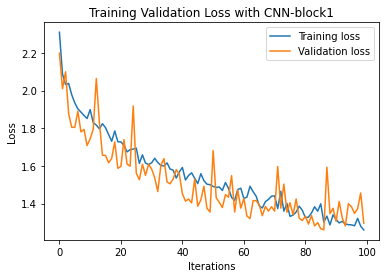

In [49]:
plot(train_losses,val_losses,'Training Validation Loss with CNN-block1')

In [50]:
all_models2 = load(save_path2 + "cnn_b12_all_models.pkl")
FILE  = all_models2[-1]
m2 = Model_B12(make_layers2(cfg2['B12'])).to(device) 

In [51]:
m2 = load_best(all_models2,m2)

In [52]:
train_y, train_y_hat = test(train_dataloader, m2, criterion2, device, "TRAIN")

TRAIN Loss: 1.062127

TRAIN Accuracy: 61% (2756/4500)


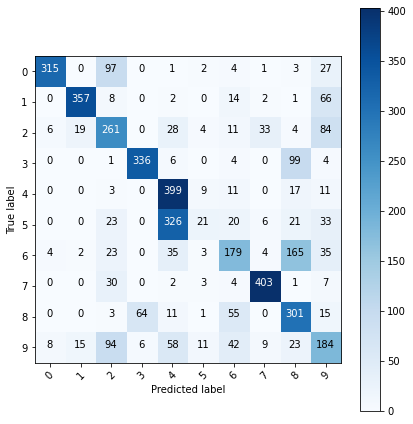

In [53]:
cm = MetricTools.confusion_matrix(train_y, train_y_hat, nclasses=10)
PlotTools.confusion_matrix(cm, [i for i in range(10)], title='',
                           filename='Confusion Matrix with CNN', figsize=(6,6))

In [54]:
test_y, test_y_hat = test(test_dataloader, m2, criterion2, device,"TEST")

TEST Loss: 1.257985

TEST Accuracy: 54% (272/500)


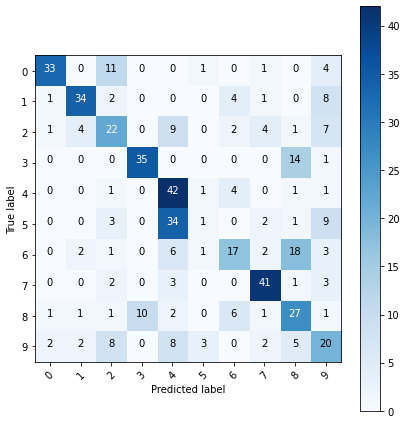

In [55]:
cm = MetricTools.confusion_matrix(test_y, test_y_hat, nclasses=10)
PlotTools.confusion_matrix(cm, [i for i in range(10)], title='',
                           filename='Confusion Matrix with CNN', figsize=(6,6))

## CNN-Block-123

### model 

In [56]:
cfg3 = {
    'B123': [16,16,'M',32,32,32,'M',64,'M'],
}

In [57]:
def make_layers3(cfg, batch_norm=True):

    layers = []
    in_channels = 3
    for v in cfg:
        if v == 'M':
            layers += [nn.MaxPool2d(kernel_size=2, stride=2)]
        elif v == 'M1':
            layers += [nn.MaxPool2d(kernel_size=2, stride=1)]
        else:
            conv2d = nn.Conv2d(in_channels, v, kernel_size=3)
            if batch_norm:
                layers += [conv2d, nn.BatchNorm2d(v), nn.ReLU(inplace=True)]
            else:
                layers += [conv2d, nn.ReLU(inplace=True)]
            in_channels = v

    return nn.Sequential(*layers)

In [58]:
class Model_B123(nn.Module):
    '''
        Model
    '''
    def __init__(self, features):

        super(Model_B123, self).__init__()
        self.features = features 

        self.classifier = nn.Sequential(
            # nn.Linear(1024, 512),
            # nn.ReLU(True),
            # nn.Linear(512, 256),
            # nn.ReLU(True),
            # nn.Linear(256, 64),
            # nn.ReLU(True),
            nn.Dropout(0.7),
            nn.Linear(64, 10),
        )
       
    def forward(self, x):
        x = self.features(x)
        # print(x.shape)
        x = x.view(x.size(0), -1)
        
        x = self.classifier(x)
        return x

In [59]:
# m = Model_B123(make_layers3(cfg3['B123']))
# for i,l in train_dataloader:
#   o = m(i)

In [60]:
model3 = Model_B123(make_layers3(cfg3['B123'])).to(device) 
learning_rate = 0.01
criterion3 = nn.CrossEntropyLoss()
optimizer3 = optim.Adam(model3.parameters(), lr=learning_rate)
print(model3)

Model_B123(
  (features): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1))
    (4): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
    (8): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace=True)
    (10): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1))
    (11): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace=True)
    (13): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1))
    (14): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (15): ReLU(inplace

### train 

In [61]:
# !rm  '/content/drive/MyDrive/SEM-2/05-DL /Assignments/A3/models_saved_Q1/1_3/bw_fc/Dropout(0.7)/cnn_block123/'*
# !ls  '/content/drive/MyDrive/SEM-2/05-DL /Assignments/A3/models_saved_Q1/1_3/bw_fc/Dropout(0.7)/cnn_block123/'

In [62]:
save_path3 = "/content/drive/MyDrive/SEM-2/05-DL /Assignments/A3/models_saved_Q1/1_3/bw_fc/Dropout(0.7)/cnn_block123/"

In [63]:
m, train_losses, val_losses,m_all_models = train(save_path3,100,train_dataloader,model3,test_dataloader,optimizer3,criterion3,"cnn_b123")

Epoch: 1 	Training Loss: 1.964496 	Validation Loss: 2.167951 Test Accuracy: 0.287
Saving model..1
Epoch: 2 	Training Loss: 1.671053 	Validation Loss: 2.556755 Test Accuracy: 0.248
Epoch: 3 	Training Loss: 1.611608 	Validation Loss: 1.587634 Test Accuracy: 0.436
Saving model..2
Epoch: 4 	Training Loss: 1.533938 	Validation Loss: 1.441043 Test Accuracy: 0.481
Saving model..3
Epoch: 5 	Training Loss: 1.478501 	Validation Loss: 1.429465 Test Accuracy: 0.475
Saving model..4
Epoch: 6 	Training Loss: 1.417404 	Validation Loss: 1.615166 Test Accuracy: 0.451
Epoch: 7 	Training Loss: 1.368179 	Validation Loss: 2.321375 Test Accuracy: 0.324
Epoch: 8 	Training Loss: 1.314496 	Validation Loss: 1.251707 Test Accuracy: 0.571
Saving model..5
Epoch: 9 	Training Loss: 1.236169 	Validation Loss: 1.149879 Test Accuracy: 0.578
Saving model..6
Epoch: 10 	Training Loss: 1.190580 	Validation Loss: 1.215191 Test Accuracy: 0.555
Epoch: 11 	Training Loss: 1.181373 	Validation Loss: 1.237790 Test Accuracy: 0.585


### Tests and Plots 

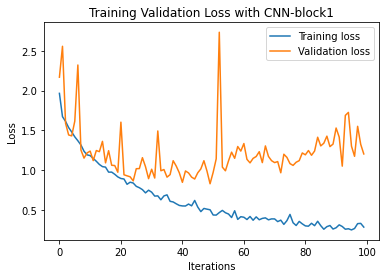

In [64]:
plot(train_losses,val_losses,'Training Validation Loss with CNN-block1')

In [65]:
all_models3 = load(save_path3 + "cnn_b123_all_models.pkl")
FILE  = all_models3[-1]
m3 = Model_B123(make_layers3(cfg3['B123'])).to(device) 

In [66]:
m3 = load_best(all_models3,m3)

In [67]:
train_y, train_y_hat = test(train_dataloader, m3, criterion3, device, "TRAIN")

TRAIN Loss: 0.213234

TRAIN Accuracy: 93% (4206/4500)


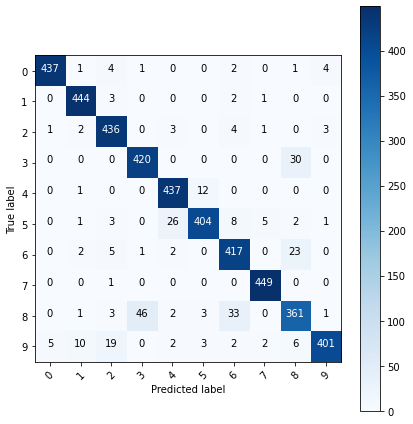

In [68]:
cm = MetricTools.confusion_matrix(train_y, train_y_hat, nclasses=10)
PlotTools.confusion_matrix(cm, [i for i in range(10)], title='',
                           filename='Confusion Matrix with CNN', figsize=(6,6))

In [69]:
test_y, test_y_hat = test(test_dataloader, m3, criterion3, device,"TEST")

TEST Loss: 0.833252

TEST Accuracy: 78% (390/500)


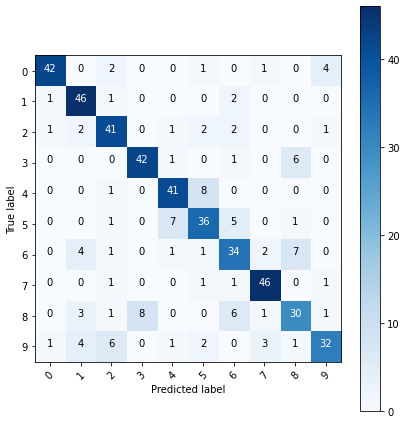

In [70]:
cm = MetricTools.confusion_matrix(test_y, test_y_hat, nclasses=10)
PlotTools.confusion_matrix(cm, [i for i in range(10)], title='',
                           filename='Confusion Matrix with CNN', figsize=(6,6))